#  Сколько нужно наблюдений

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from tqdm import tqdm as tqdm_botebook

plt.style.use('ggplot')
%matplotlib inline

# 1. Гипотеза о кнопке

Посмотрим на пример с долями. У нас есть две кнопки: старая и новая. Мы хотим проверить гипотезу о том, что доля нажатий по обеим кнопкам совпадает. В качестве альтернативы рассматриваем вариант, что новый дизайн кнопки оказался лучше и нажать на неё хочется больше.

$$
\begin{aligned}
&H_0: \hspace{2mm} p_0 = p_a \\
&H_1: \hspace{2mm} p_0 < p_a  
\end{aligned}
$$

Величины $p_0$ и $p_a$ мы оцениваем, как отношение кликов на кнопку к показам в контрольной группе и в тестовой группе. Число наблюдений, которое нам необходимо, в таком случае, можно найти по формуле: 

$$
n = \left( \frac{\sqrt{p_0 \cdot (1 - p_0) } \cdot z_{1 - \alpha} + \sqrt{p_a \cdot (1 - p_a) } \cdot z_{1 - \beta} }{p_a - p_0}  \right)^2,
$$

где $n$- число наблюдений, $\alpha$ - ошибка первого рода, $\beta$ - ошибка второго рода, $z_{1 - \alpha}, z_{1 - \beta}$ - квантили нормального распределения. 


In [2]:
def get_size(p0, pa, alpha, beta):
    za = stats.norm.ppf(1 - alpha)
    zb = stats.norm.ppf(1 - beta)    
    n = za * np.sqrt(p0*(1 - p0)) + zb * np.sqrt(pa*(1-pa))
    n /= (pa - p0)
    return int(np.ceil(n*n))

alpha = 0.05
beta = 0.05

# сколько наблюдений надо, чтобы получить ошибки alpha и beta и уловить минимальный эффект pa - p0
get_size(0.1, 0.15, alpha, beta) 

468

Теперь посчитаем тоже самое с помощью пакета `statsmodels`. Внутри него есть функция `zt_ind_solve_power`. Она может использоваться, чтобы найти любой из параметров: мощность, число наблюдений, эффект, уровень значимости. Три известные части информации подставляются в функцию. Вместо неизвестной пишется `None`. 

Обратите внимание, что в качестве размера эффекта в функцию подаётся стандартизированный эффект, а не оригинальный (отнормированный на стандартное отклонение)

$$
effect = \frac{p_0 - p_a}{se},
$$

при этом стандартная ошибка считается как 

$$
se = \sqrt{\frac{(n_1 - 1)\cdot s_1^2 + (n_2 - 1) \cdot s_2^2 }{n_1 + n_2 - 2}}.
$$

In [3]:
n_0, n_a = 468, 468   # размеры выборок
p_0, p_a = 0.1, 0.15  # доли 

# дисперсии
var_0, var_a = p_0 * (1 - p_0),  p_a * (1 - p_a)

# стандартизированный размер эффекта
(p_a - p_0) / ((n_0 * np.sqrt(var_0) + n_a * np.sqrt(var_a)) / (n_0 + n_a))

0.1521904571390466

In [4]:
from statsmodels.stats.power import zt_ind_solve_power

alpha = 0.05
beta = 0.05

# параметр ratio отвечает за то в какой из двух выборок больше наблюдений
sample_size = zt_ind_solve_power(
                    effect_size=0.15219,  # стандартизованный размер эффекта
                    nobs1=None,           # число наблюдений None, тк их хотим найти 
                    alpha=alpha,          # уровень значимости 
                    power=(1 - beta),     # мощность
                    ratio=1,              # перекос в выборках, если 0, тогда выборка только одна
                    alternative='larger'  # альтернатива
                )

print(sample_size/2) # у нас две выборки, на каждую поровну

467.2424266951237


Подставив `None` вместо другого аргумента функции, можем рассчитать что-нибудь ещё. Например, мощность теста.

In [5]:
zt_ind_solve_power(effect_size=0.15219, 
                   nobs1=100, 
                   alpha=alpha,
                   power=None, 
                   ratio=1,
                   alternative='larger')

0.2847772211312768

Или размер эффекта. 

In [6]:
zt_ind_solve_power(effect_size=None, 
                   nobs1=2*467, 
                   alpha=alpha, 
                   power=1-beta, 
                   ratio=1, 
                   alternative='larger')

0.1522295561785361

По аналогии можно работать с любой асимптотически нормальной статистикой. 

# 2. Другие тесты

По аналогии реализованы [многие другие тесты.](https://www.statsmodels.org/stable/stats.html) Например, тест Стьюдента. Рассмотрим тест для равенства средних при неизвестных, но равных дисперсиях. 

Класс `TTestIndPower` предназначен для анализа мощности для t-теста Стьюдента с независимыми выборками (`TTestPower` для обычного либо с зависимыми выборками).

У каждого объекта этого класса есть метод `solve_power`. Он может использоваться, чтобы найти любой из параметров: мощность, число наблюдений, эффект, уровень значимости. Три известные части информации подставляются в функцию. Вместо неизвестной ствится `None`. 

Снова в качестве эффекта на вход идёт стандартизованный эффект: 

$$
effect = \frac{\bar{x_1} - \bar{x_2}}{se},
$$


In [7]:
from statsmodels.stats.power import TTestIndPower

effect = 0.5
alpha = 0.05
power = 0.95

analysis = TTestIndPower()
analysis.solve_power(effect, 
                     power=power, 
                     nobs1=None, 
                     alpha=alpha, 
                     ratio=1)

104.92794663444292

# 3. Кривые мощности

Построим для мощностей кривые. Они будут показывать размер эффекта и размер выборки влияют на мощность теста. 

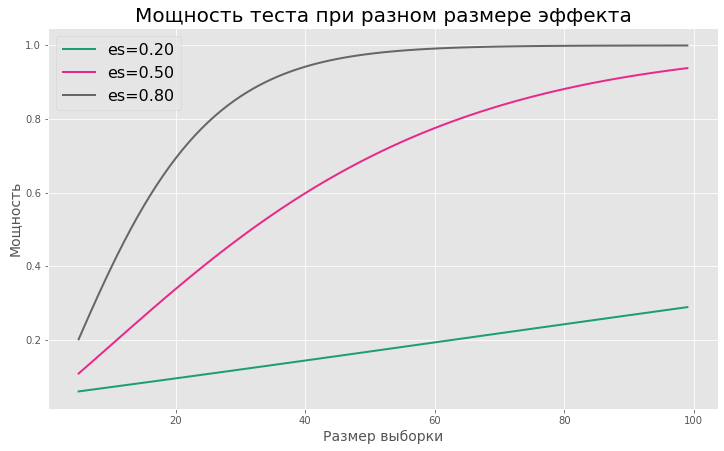

In [8]:
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, 100))

analysis = TTestIndPower()

_, axes = plt.subplots(1, 1, figsize=(12,7))

analysis.plot_power(
    dep_var='nobs',
    nobs=sample_sizes, 
    effect_size=effect_sizes,
    ax=axes
)

axes.set_title("Мощность теста при разном размере эффекта", fontsize=20)
axes.set_xlabel("Размер выборки", fontsize=14)
axes.set_ylabel("Мощность", fontsize=14)
plt.legend(fontsize=16);

На графике мы видим как меняется мощность критерия при трёх разных размерах эффекта. Если нас интересует большой эффект, то мы выходим к единице при примерно $60$ наблюдениях.